### **D2APR: Aprendizado de Máquina e Reconhecimento de Padrões** (IFSP, Campinas) <br/>
**Trabalho 1 - Sao Paulo Real Estate**

Aluno: Hugo Martinelli Watanuki

Matrícula: 3016692

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>. <br/><br/>

In [3]:
# Imports and default settings for plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

#**1. Problem description and dataset**

##1.1 Problem statement
Stablishing the correct rental value for an apartment in Sao Paulo can be very challenging.

Irrespective of you being the owner or the tenant of the apartment, both parties want to ensure they are practicing prices that are in accordance with the most up to date values being practiced in the market.

However, the rental prices in a large metropolitan area like São Paulo can be influenced by serveral different factors, including not only internal attributes of the apartment, such as square footage and number of bedrooms,but also external elements such as its localization and surrounding infrastructure.

Therefore, the goal of this notebook is to develop a machine learning model that can help owner and tenants interested in renting an apartment to predict the a reference rental price according to the market standards. To this aim, a dataset containing records of apartments from Sao Paulo and their corresponding attributes will be leveraged and submitted to a supervised machine learning approach.





##1.2 Dataset overview

The dataset being leveraged in this notebook is available from kaggle: https://www.kaggle.com/datasets/argonalyst/sao-paulo-real-estate-sale-rent-april-2019/

The dataset contains around 13,640 records where each instance represent an apartment either for sale or for rent in the city of São Paulo, Brazil. The data comes from multiple sources, specially real estate classified websites.

The dataset represents properties advertised in the month of April 2019.


In [68]:
# Loading the dataset
housing = pd.read_csv('./sample_data/sao-paulo-properties-april-2019.csv')

In [5]:
# Visualizing the dataset
housing.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


##1.3 Dataset attributes and data types

Each instance of the dataset corresponds to one apartment and is represented by 16 attributes (9 numeric and 7 categorical).

*   Price: Final price advertised (R$ Brazilian Real)
*   Condo: Condominium expenses (unknown values are marked as zero)
*   Size: The property size in Square Meters m² (private areas only)
*   Rooms: Number of bedrooms
*   Toilets: Number of toilets (all toilets)
*   Suites: Number of bedrooms with a private bathroom (en suite)
*   Parking: Number of parking spots
*   Elevator: Binary value: 1 if there is elevator in the building, 0 otherwise
*   Furnished: Binary value: 1 if the property is funished, 0 otherwise
*   Swimming Pool: Binary value: 1 if the property has swimming pool, 0 otherwise
*   New: Binary value: 1 if the property is very recent, 0 otherwise
*   District: The neighborhood and city where the property is located, e.i: Itaim Bibi/São Paulo
*   Negotiation Type: Sale or Rent
*   Property Type: The property type
*   Latitude: Geographic location
*   Longitude: Geographic location

There are no missing values reported in any of the features, but the feature "Condo" has unknown values represented as zero.


In [6]:
# Attributes and their types
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13640 entries, 0 to 13639
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             13640 non-null  int64  
 1   Condo             13640 non-null  int64  
 2   Size              13640 non-null  int64  
 3   Rooms             13640 non-null  int64  
 4   Toilets           13640 non-null  int64  
 5   Suites            13640 non-null  int64  
 6   Parking           13640 non-null  int64  
 7   Elevator          13640 non-null  int64  
 8   Furnished         13640 non-null  int64  
 9   Swimming Pool     13640 non-null  int64  
 10  New               13640 non-null  int64  
 11  District          13640 non-null  object 
 12  Negotiation Type  13640 non-null  object 
 13  Property Type     13640 non-null  object 
 14  Latitude          13640 non-null  float64
 15  Longitude         13640 non-null  float64
dtypes: float64(2), int64(11), object(3)
memo

#**2. Exploratory data analysis**

##2.1 Distribution of each attribute

In [7]:
# Filtering only the records for rent
housing_rent=housing[housing['Negotiation Type']=='rent']
housing_rent

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11205,3700,595,73,1,2,1,1,0,0,1,0,Brooklin/São Paulo,rent,apartment,-23.617682,-46.694963
11206,21000,3000,208,4,4,3,3,1,1,1,0,Brooklin/São Paulo,rent,apartment,-23.606891,-46.695934
11207,3800,710,55,1,1,0,1,0,1,1,0,Brooklin/São Paulo,rent,apartment,0.000000,0.000000
11208,5000,2354,205,3,2,1,2,1,0,0,0,Brooklin/São Paulo,rent,apartment,-23.612287,-46.681482


In [69]:
housing_rent.duplicated().any()

True

In [8]:
housing_rent['Negotiation Type'].value_counts()

rent    7228
Name: Negotiation Type, dtype: int64

In [9]:
housing['Property Type'].value_counts()

apartment    13640
Name: Property Type, dtype: int64

In [10]:
# Descriptive statistics of each attribute
housing_rent.describe(include='all')

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
count,7228.000000,7228.000000,7228.000000,7228.000000,7228.000000,7228.000000,7228.000000,7228.000000,7228.000000,7228.000000,7228.000000,7228,7228,7228,7228.000000,7228.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94,1,1,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mooca/São Paulo,rent,apartment,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,178,7228,7228,NaN,NaN
mean,3077.669065,825.194798,89.486165,2.304234,2.105562,1.024488,1.452269,0.299806,0.172939,0.487963,0.000830,NaN,NaN,NaN,-22.032278,-43.500873
std,3522.830284,835.621937,63.976416,0.829108,0.998162,0.884241,0.889535,0.458205,0.378220,0.499890,0.028802,NaN,NaN,NaN,5.962534,11.675070
min,480.000000,0.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,-46.749039,-58.364352
25%,1350.000000,395.750000,52.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,-23.598066,-46.689788
50%,2000.000000,595.000000,67.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,-23.555869,-46.644793
75%,3300.000000,990.000000,100.000000,3.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,-23.522756,-46.585110


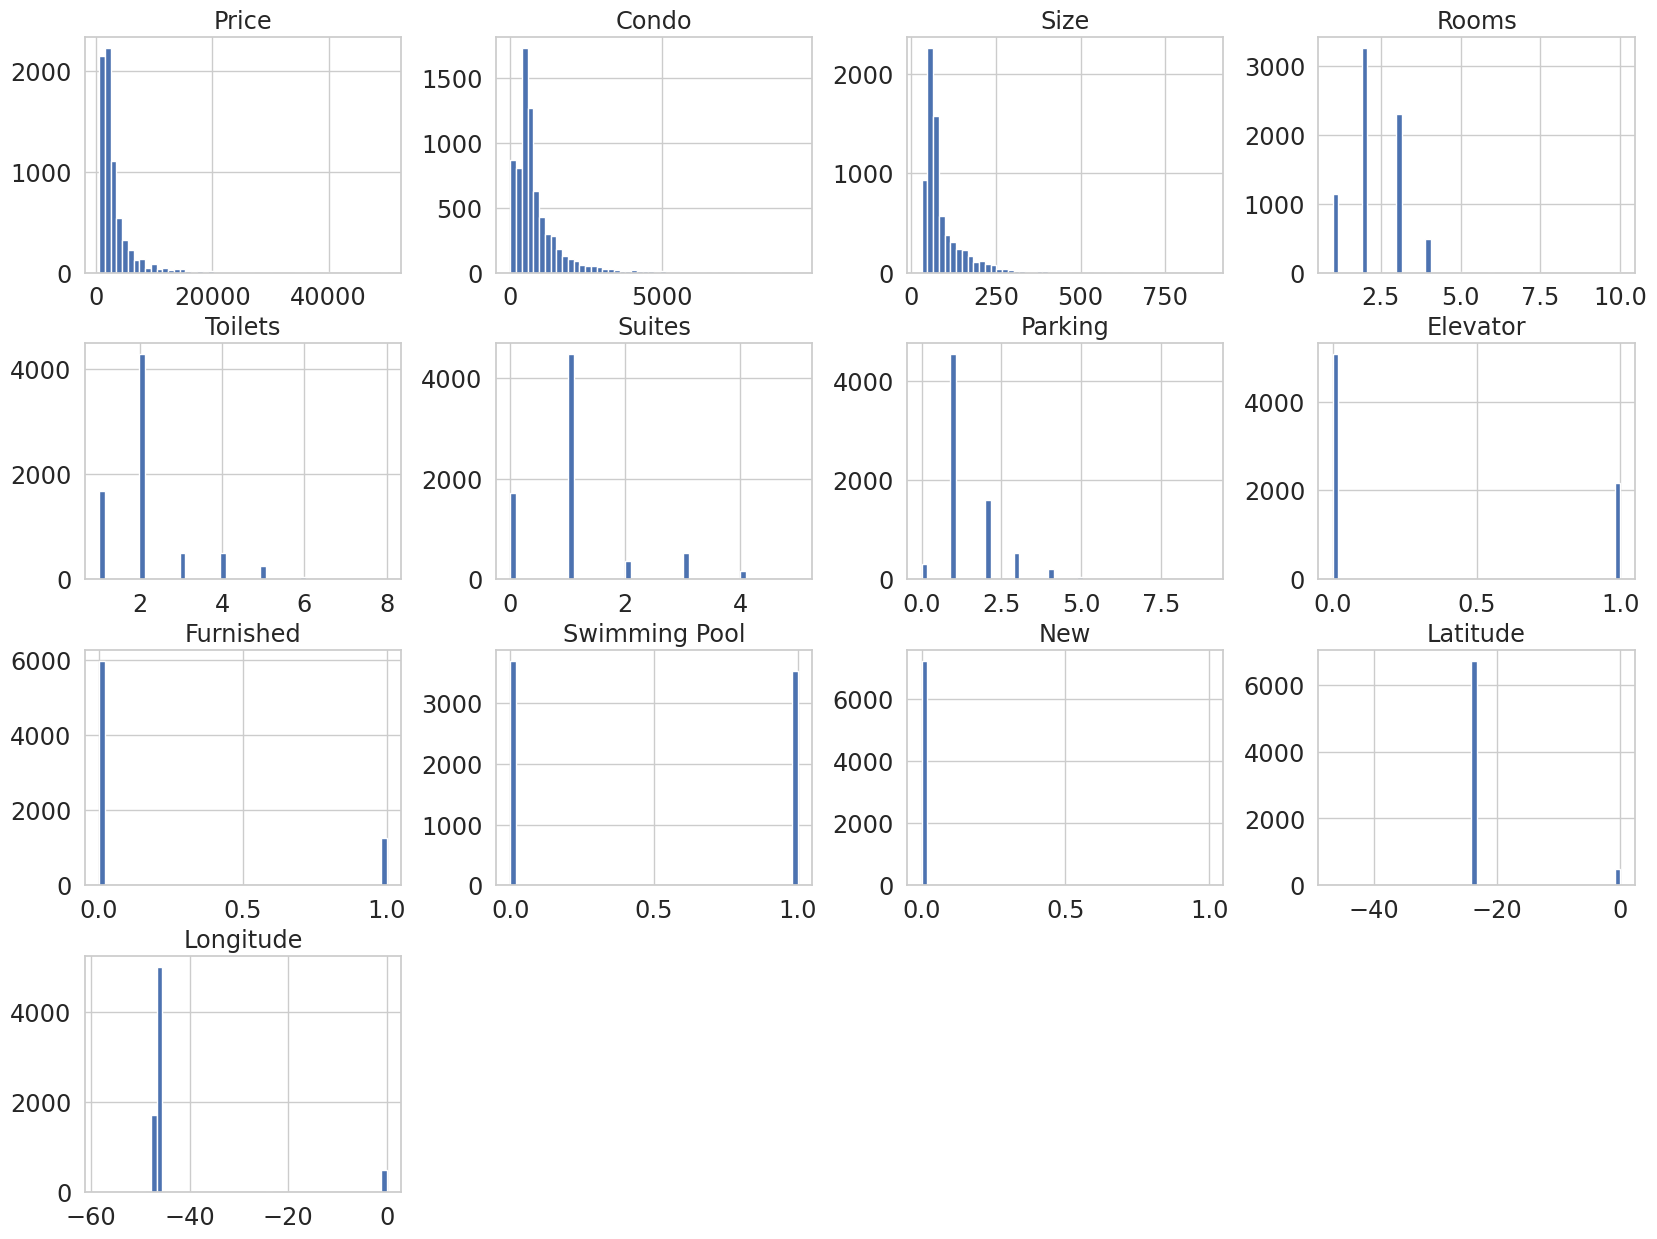

In [11]:
# Plotting an histogram for each numeric attibute from the dataframe
housing_rent.hist(bins=50, figsize=(20,15))
display()  # just to avoid texts in the notebook output

In [12]:
#
housing_rent['District'].value_counts()

Mooca/São Paulo              178
Moema/São Paulo              163
Vila Mariana/São Paulo       161
Morumbi/São Paulo            159
Pinheiros/São Paulo          153
                            ... 
Lajeado/São Paulo              8
Guaianazes/São Paulo           6
Parque do Carmo/São Paulo      6
Jardim São Luis/São Paulo      3
Grajaú/São Paulo               2
Name: District, Length: 94, dtype: int64

##2.2 Correlation among each numeric attribute

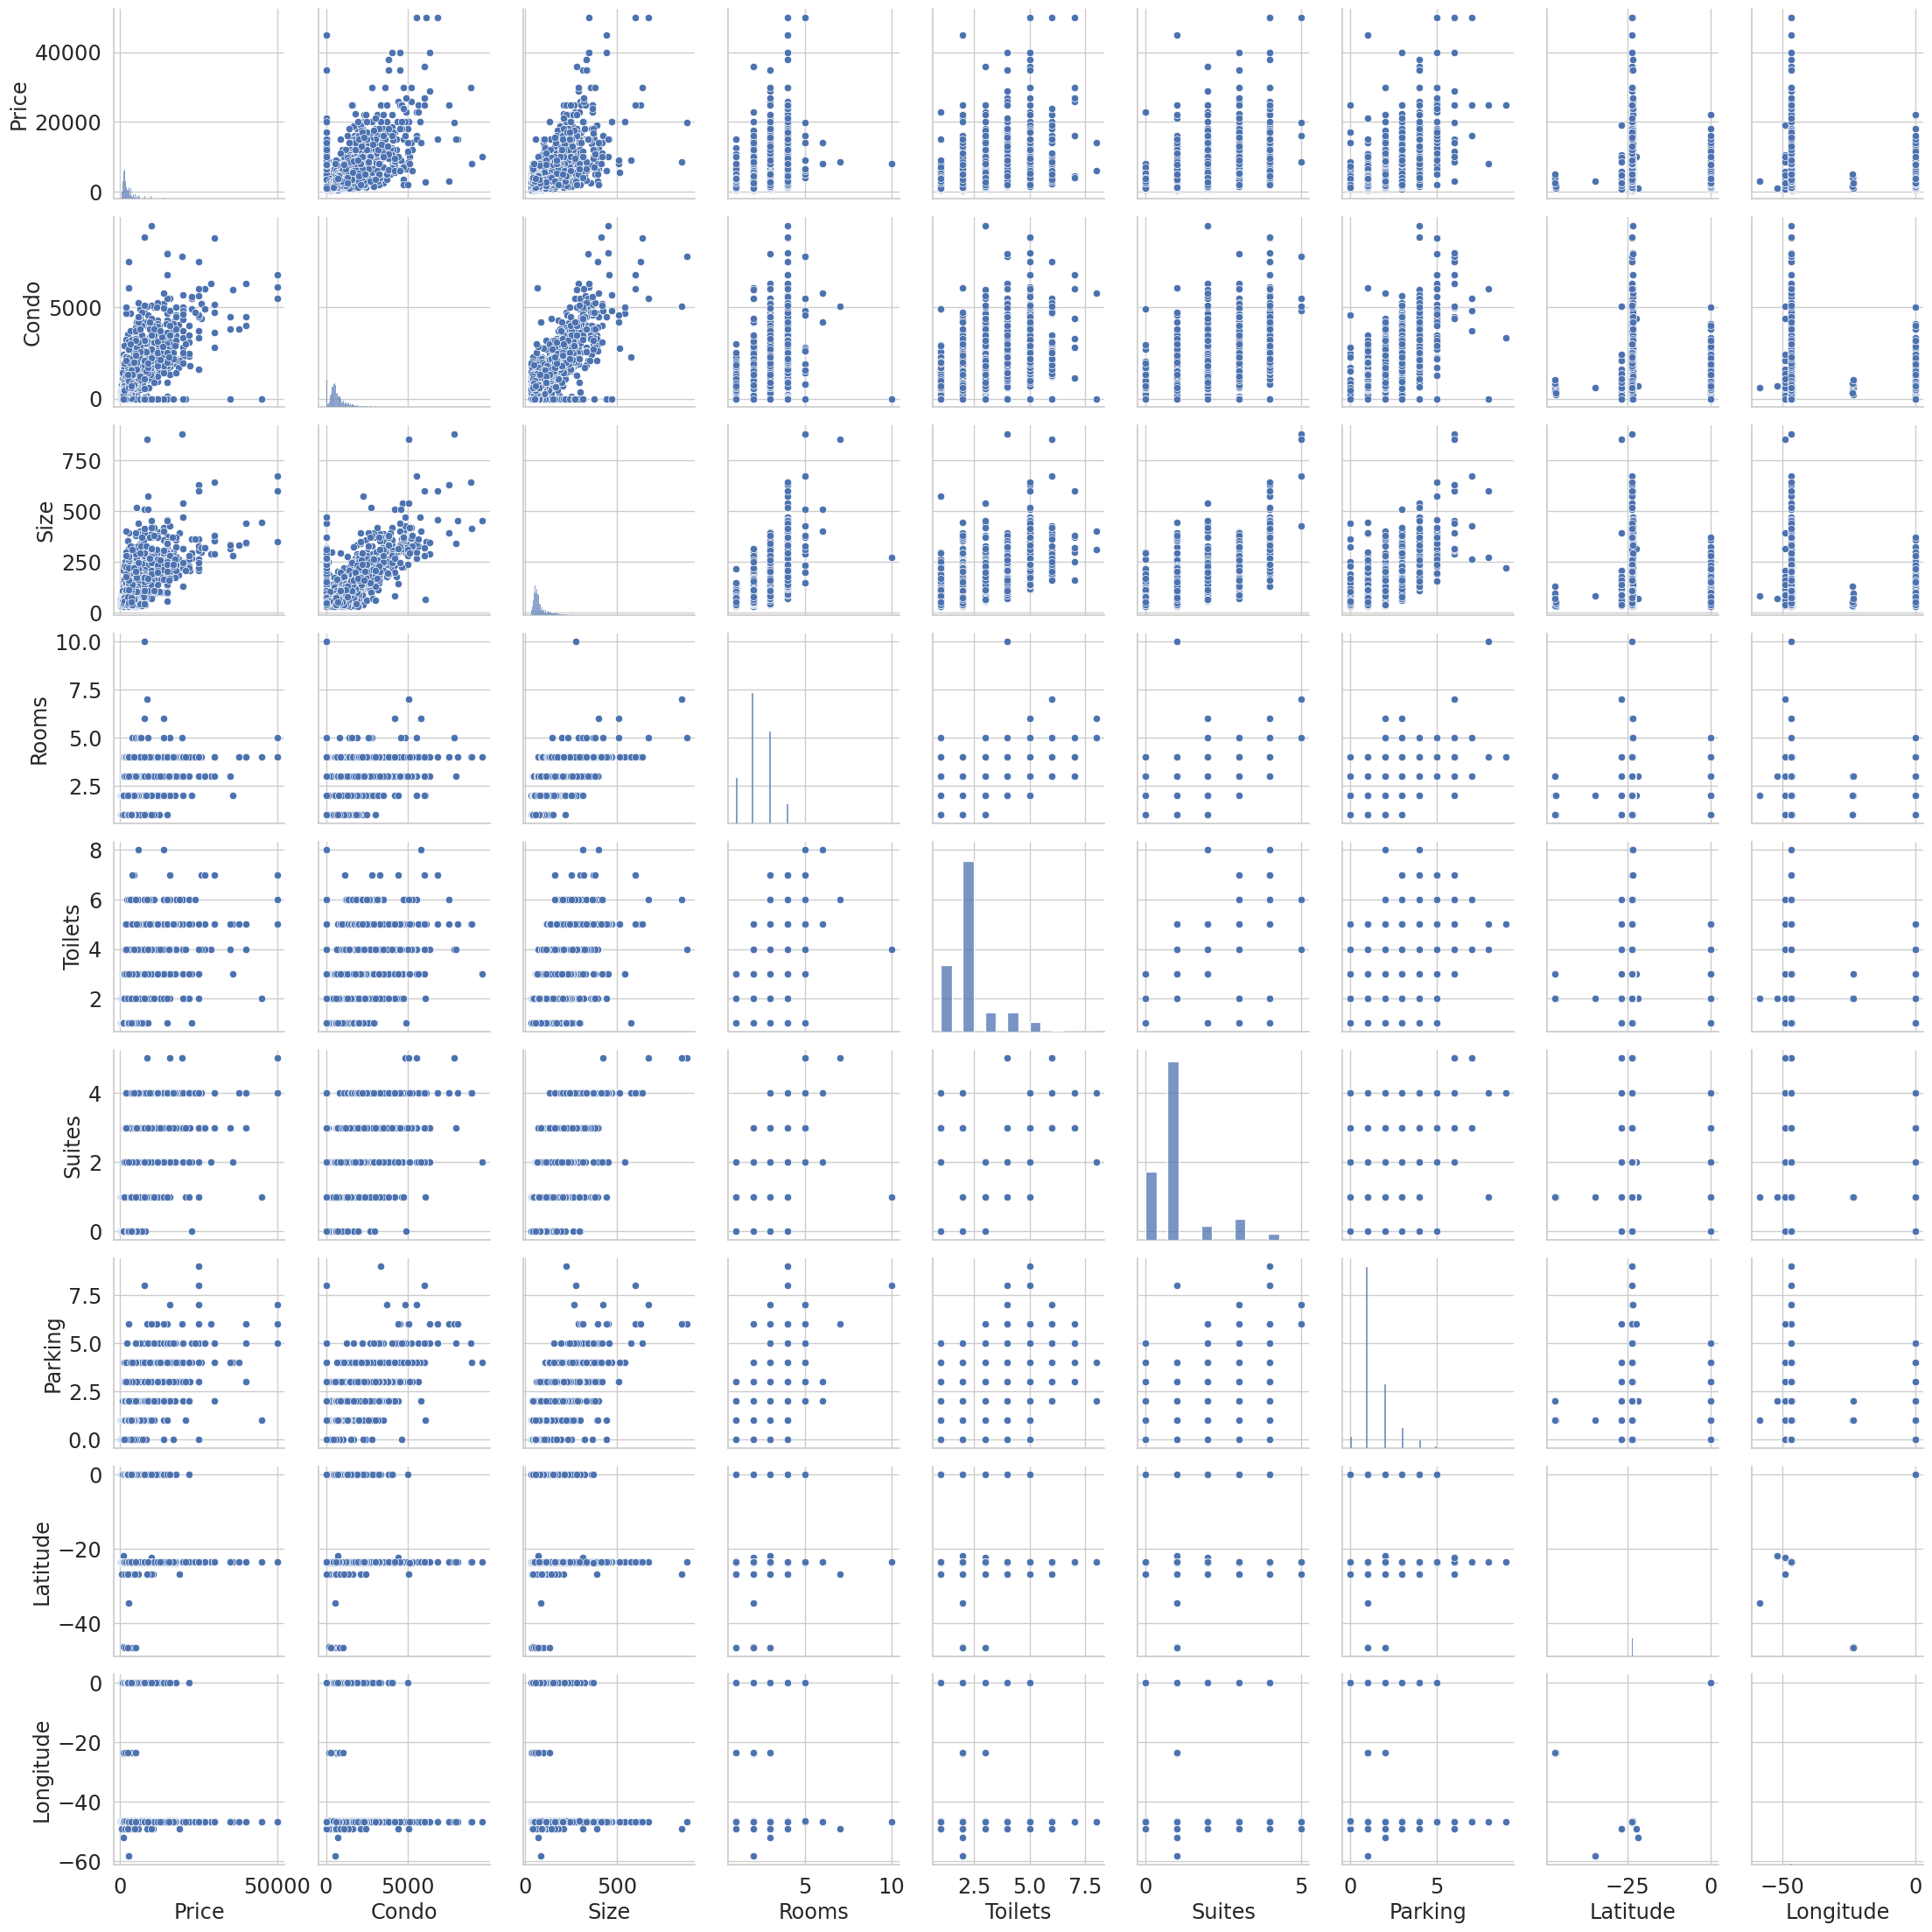

In [13]:
# 9 numeric attributes ==> 9 x 9 = 81 plots
sns.pairplot(housing_rent, vars=["Price","Condo","Size","Rooms","Toilets","Suites","Parking","Latitude","Longitude"])

<ipython-input-14-1bd6b8d08285>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(housing_rent.corr(numeric_only=True), dtype=np.bool))  # creates a triangular matrix based on the pandas correlation matrix


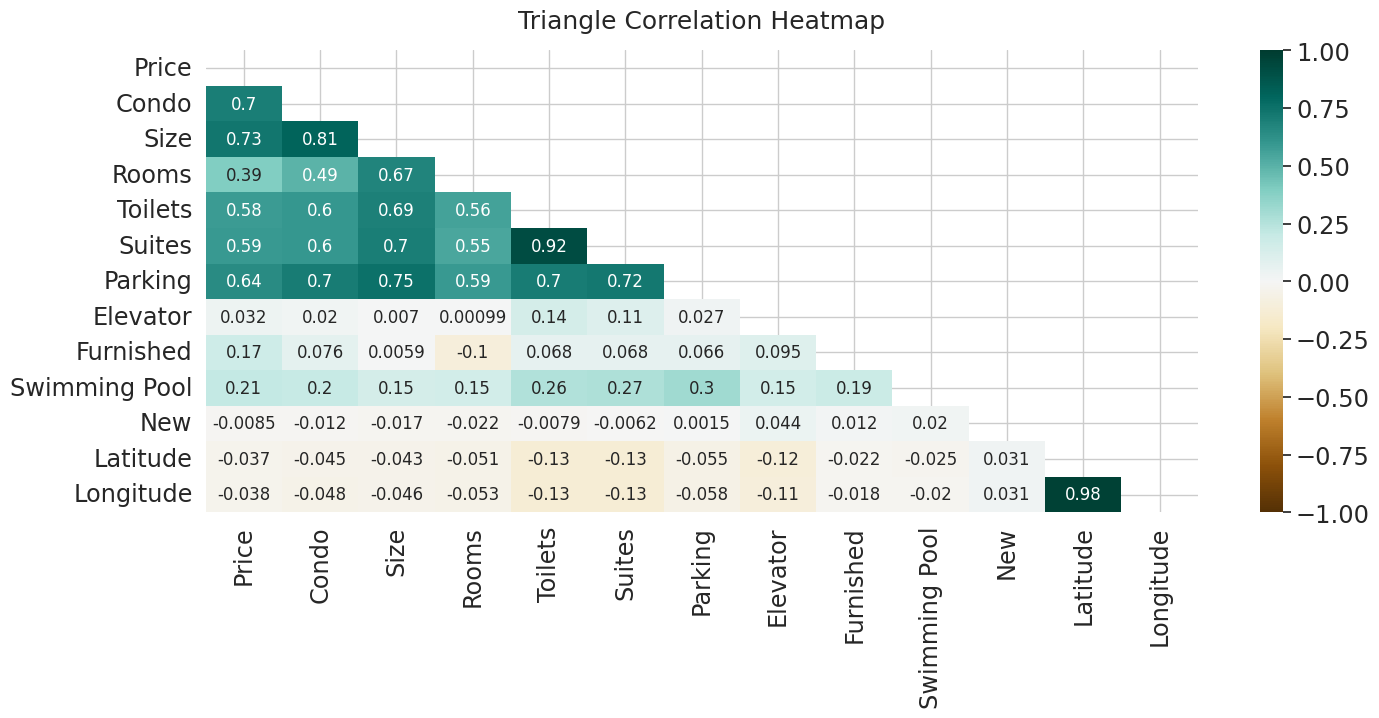

In [14]:
# Plotting the correlation coeficients as a heatmap
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(housing_rent.corr(numeric_only=True), dtype=np.bool))  # creates a triangular matrix based on the pandas correlation matrix

heatmap = sns.heatmap(housing_rent.corr(numeric_only=True), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [15]:
# Sorting the attributes by descending order of correlation
housing_rent.corr(numeric_only=True)["Price"].sort_values(ascending=False)

Price            1.000000
Size             0.731795
Condo            0.700361
Parking          0.640743
Suites           0.588329
Toilets          0.583488
Rooms            0.390951
Swimming Pool    0.206884
Furnished        0.171859
Elevator         0.031860
New             -0.008477
Latitude        -0.036935
Longitude       -0.038362
Name: Price, dtype: float64

<Figure size 1000x600 with 0 Axes>

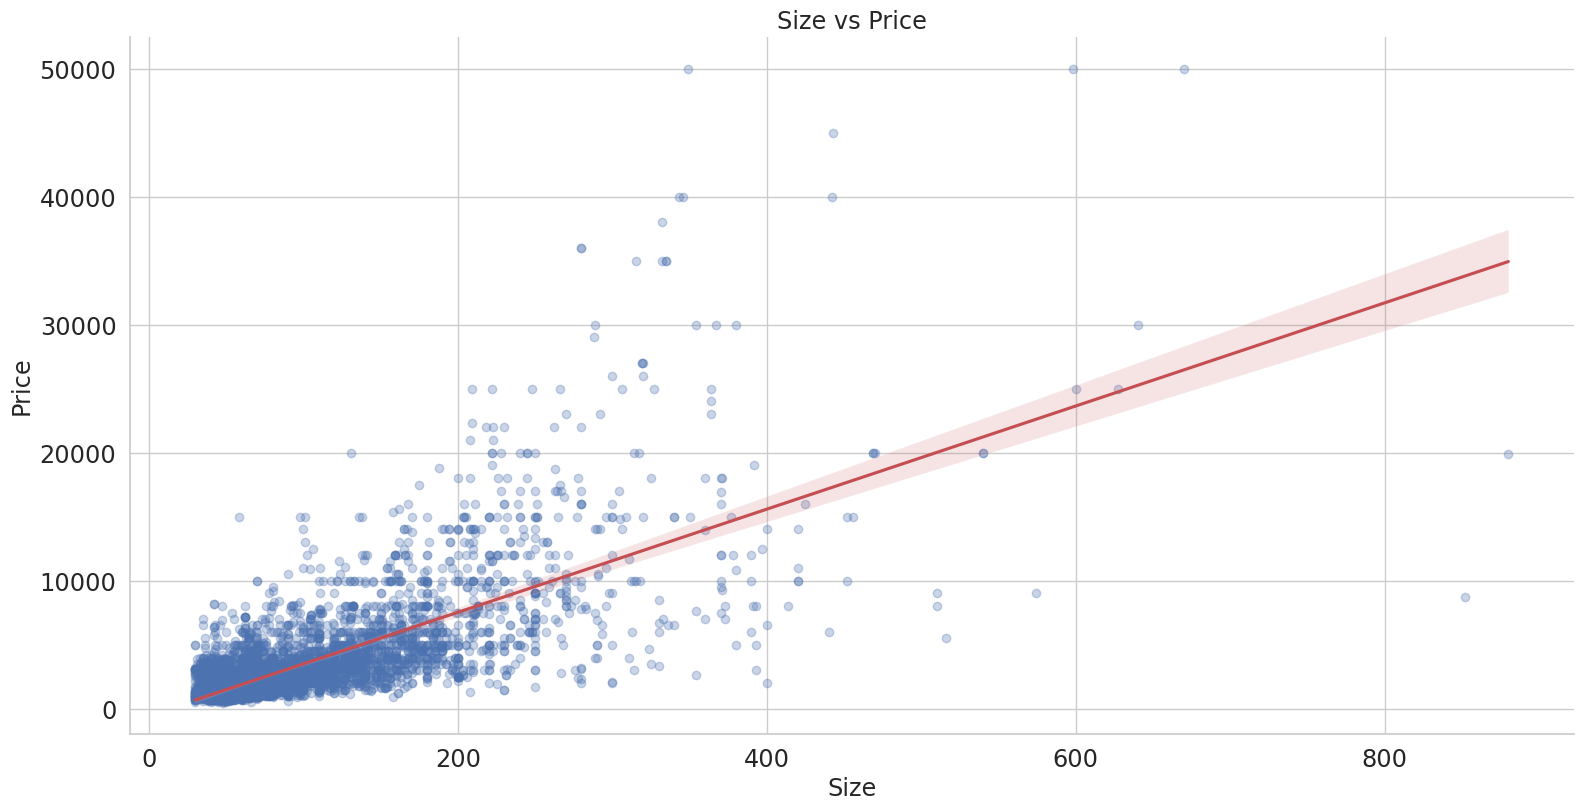

In [16]:
# Plotting the correlation between apartment size and rental price
plt.figure(figsize=(10, 6))
sns.lmplot(data=housing_rent, x="Size", y="Price", aspect=2, height=8, scatter_kws={'alpha': 0.3}, line_kws={'color': 'r'})
plt.grid(True)
plt.title('Size vs Price')
display()

##2.3 Auxiliary graphics for exploratory analysis

<Axes: xlabel='Longitude', ylabel='Latitude'>

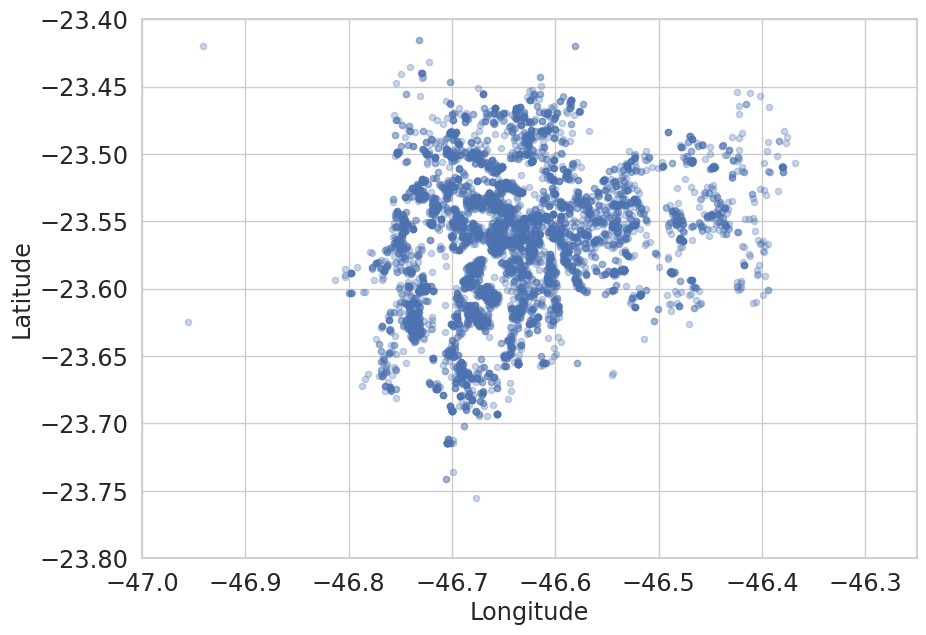

In [17]:
# Visualizing the geographical distribution of the apartments
housing_rent.plot(kind="scatter", x="Longitude", y="Latitude", xlim=(-47,-46.25), ylim=(-23.8, -23.4), alpha=0.3, figsize=(10, 7))

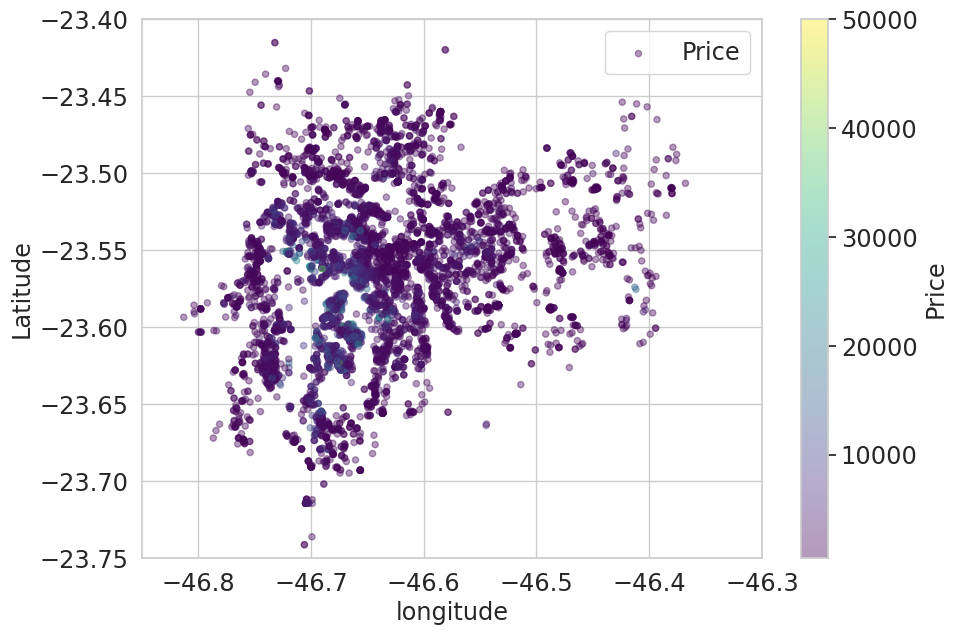

In [18]:
# Visualizing geographical distribution of the apartments and their prices
housing_rent.plot(kind="scatter", x="Longitude", y="Latitude", xlim=(-46.85,-46.3), ylim=(-23.75, -23.4), label ="Price", alpha=0.4,  figsize=(10,7), c="Price", cmap=plt.get_cmap("viridis"), colorbar=True)
plt.xlabel('longitude')
plt.legend()

In [19]:
housing_rent.columns

Index(['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking',
       'Elevator', 'Furnished', 'Swimming Pool', 'New', 'District',
       'Negotiation Type', 'Property Type', 'Latitude', 'Longitude'],
      dtype='object')

In [20]:
numeric_attributes = ['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Latitude', 'Longitude']
numeric_attributes

['Price',
 'Condo',
 'Size',
 'Rooms',
 'Toilets',
 'Suites',
 'Parking',
 'Latitude',
 'Longitude']

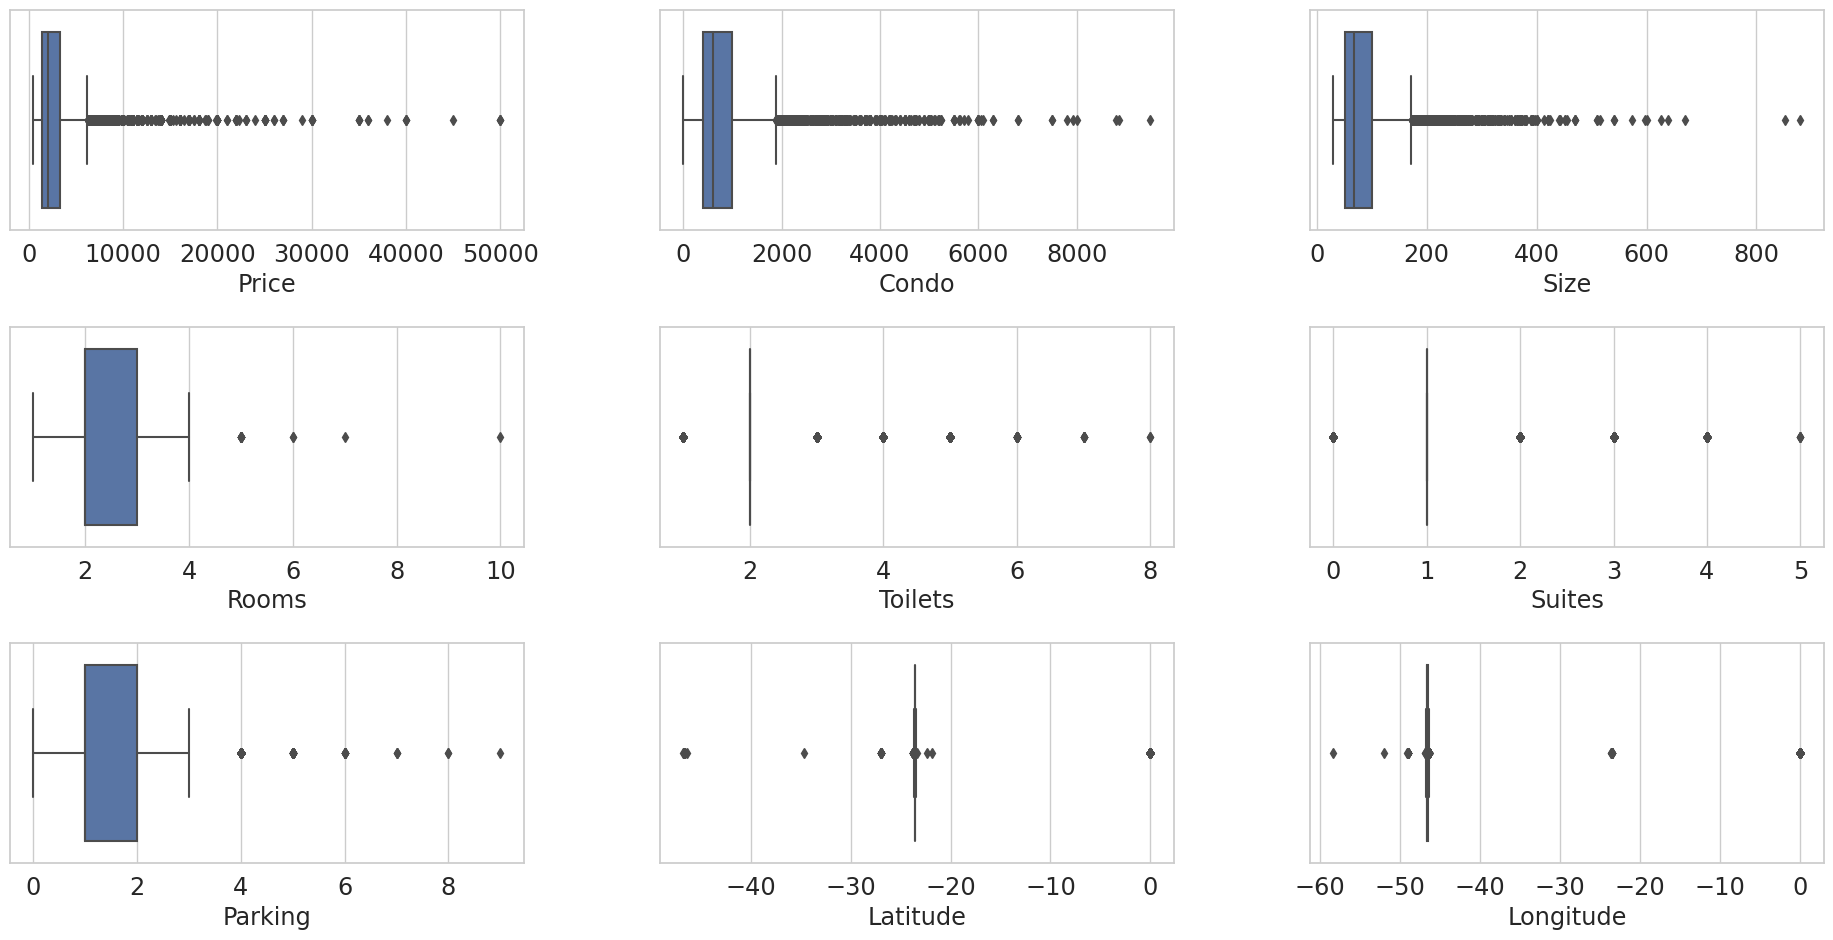

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
fig.tight_layout(pad=3.0)

for i, attr in enumerate(numeric_attributes):
    row = i // 3
    col = i % 3
    sns.boxplot(data=housing_rent, x=attr, ax=axes[row, col])

## 2.4 Main conclusions from the exploratory data analysis

After exploring the dataset, the following findings can be highlighted along with their respective remediation:

1. Two attributes from the original dataset, namely "Negotiation Type" and "Property Type", only contain constant values that do not contribute to the prediction of the rent value and therefore can be removed for more efficient analysis

2. The attribute "Condo" has unknown values displayed as zero that need to be replaced by the median value of the attribute.

3. The attribute "District" is categorical in nature and needs to be properly encoded for the machine learning training.

4. "Size" is the attribute showing the largest correlation value with the rent value and since this attribute is not uniformily distributed across its values, a stratified sampling technique will be used to avoid bias during the training of the model.

5. The geographical analysis has suggested that the apartments with the most expensive rent values are located in the central/west region of Sao Paulo which is consistent with the reality.

6. The box plot analysis has revealed that several attributes contains outliers but the will be kept as they represent real values and not noise.

#**3. Cleaning and preprocessing the dataset**



##3.1 Slicing the dataset to remove unnecessary columns

In [22]:
# Dropping columns that do not add value to the analysis (i.e., constant values)
housing_rent=housing_rent.drop(columns=['Negotiation Type','Property Type'])
housing_rent

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,-23.525025,-46.482436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11205,3700,595,73,1,2,1,1,0,0,1,0,Brooklin/São Paulo,-23.617682,-46.694963
11206,21000,3000,208,4,4,3,3,1,1,1,0,Brooklin/São Paulo,-23.606891,-46.695934
11207,3800,710,55,1,1,0,1,0,1,1,0,Brooklin/São Paulo,0.000000,0.000000
11208,5000,2354,205,3,2,1,2,1,0,0,0,Brooklin/São Paulo,-23.612287,-46.681482


##3.2 Addressing missing values for the "Condo" attribute

In [23]:
housing_rent['Condo'].value_counts()

0       640
500     174
600     152
400     146
450     132
       ... 
3721      1
5636      1
1216      1
2820      1
2354      1
Name: Condo, Length: 1192, dtype: int64

<Axes: xlabel='Condo'>

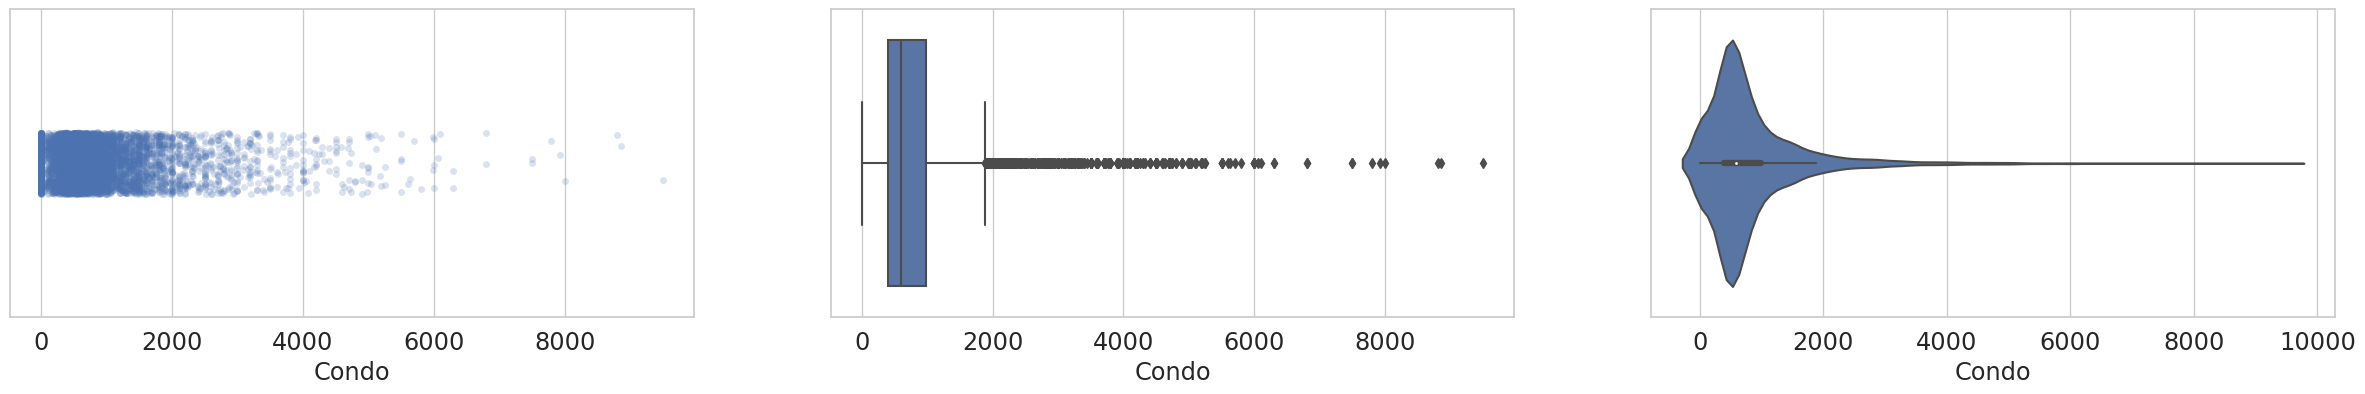

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(30, 4))

sns.stripplot(data=housing_rent, x='Condo', ax=axes[0], alpha=0.2)
sns.boxplot(data=housing_rent, x='Condo', ax=axes[1])
sns.violinplot(data=housing_rent, x='Condo', ax=axes[2])

In [25]:
housing_rent_clean = housing_rent.copy()

In [26]:
median_Condo = housing_rent_clean['Condo'].median()
median_Condo

595.0

In [27]:
mask_zeroes = housing_rent_clean[housing_rent_clean['Condo']==0]
mask_zeroes

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Latitude,Longitude
5,1170,0,50,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,-23.548751,-46.477195
8,1000,0,65,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,-23.548751,-46.477195
9,1000,0,100,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,-23.548751,-46.477195
49,1200,0,48,2,2,1,1,0,0,0,0,Cangaíba/São Paulo,-23.502336,-46.523243
50,1450,0,65,2,2,1,1,1,0,0,0,Cangaíba/São Paulo,-23.506197,-46.522358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10992,1600,0,50,2,1,0,1,1,0,0,0,Rio Pequeno/São Paulo,-23.565075,-46.750646
10993,1600,0,50,2,1,0,1,1,0,0,0,Rio Pequeno/São Paulo,-23.565075,-46.750646
11137,1650,0,40,1,2,1,1,0,1,0,0,Brooklin/São Paulo,-23.621386,-46.683703
11179,7900,0,153,3,2,1,3,0,1,1,0,Mooca/São Paulo,0.000000,0.000000


In [28]:
housing_rent_clean['Condo'] = housing_rent_clean['Condo'].replace(0, median_Condo)

In [29]:
mask_zeroes = housing_rent_clean[housing_rent_clean['Condo']==0]
mask_zeroes

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Latitude,Longitude


In [30]:
#housing_rent.loc[24]
housing_rent_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7228 entries, 0 to 11209
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Price          7228 non-null   int64  
 1   Condo          7228 non-null   int64  
 2   Size           7228 non-null   int64  
 3   Rooms          7228 non-null   int64  
 4   Toilets        7228 non-null   int64  
 5   Suites         7228 non-null   int64  
 6   Parking        7228 non-null   int64  
 7   Elevator       7228 non-null   int64  
 8   Furnished      7228 non-null   int64  
 9   Swimming Pool  7228 non-null   int64  
 10  New            7228 non-null   int64  
 11  District       7228 non-null   object 
 12  Latitude       7228 non-null   float64
 13  Longitude      7228 non-null   float64
dtypes: float64(2), int64(11), object(1)
memory usage: 847.0+ KB


#3.3 Enconding of the categorial variable "District"

In [31]:
housing_rent_clean['District'].value_counts()

Mooca/São Paulo              178
Moema/São Paulo              163
Vila Mariana/São Paulo       161
Morumbi/São Paulo            159
Pinheiros/São Paulo          153
                            ... 
Lajeado/São Paulo              8
Guaianazes/São Paulo           6
Parque do Carmo/São Paulo      6
Jardim São Luis/São Paulo      3
Grajaú/São Paulo               2
Name: District, Length: 94, dtype: int64

In [32]:
# one hot encoding by pandas
housing_rent_clean_encod = pd.get_dummies(data=housing_rent_clean, columns=['District'])
housing_rent_clean_encod.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,...,District_Vila Jacuí/São Paulo,District_Vila Leopoldina/São Paulo,District_Vila Madalena/São Paulo,District_Vila Maria/São Paulo,District_Vila Mariana/São Paulo,District_Vila Matilde/São Paulo,District_Vila Olimpia/São Paulo,District_Vila Prudente/São Paulo,District_Vila Sônia/São Paulo,District_Água Rasa/São Paulo
0,930,220,47,2,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000,148,45,2,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1000,100,48,2,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000,200,48,2,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1300,410,55,2,2,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Persisting the removal of the columns
housing_rent_clean_encod.to_csv('./sample_data/housing_rent_clean_encod.csv', index=False)

##3.4 Preparing stratified samples

<Axes: xlabel='Size', ylabel='Count'>

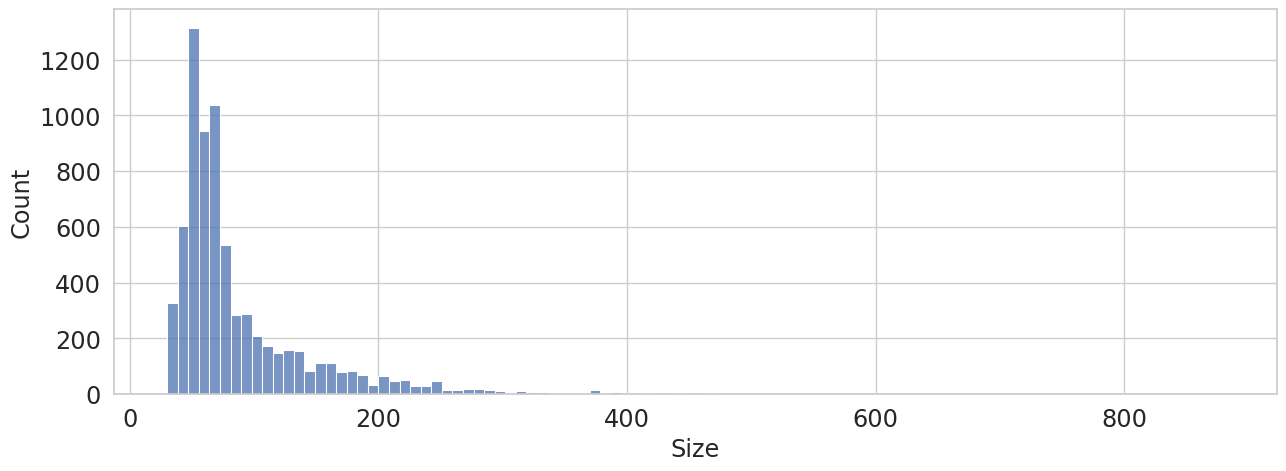

In [34]:
sns.histplot(data=housing_rent_clean_encod, x='Size', bins=100)

Group 1: [0, 50]
Group 2: (50, 100]
Group 3: (100, 150]
Group 4: (150, +]


In [35]:
housing_rent_clean_encod['Size'].describe()

count    7228.000000
mean       89.486165
std        63.976416
min        30.000000
25%        52.000000
50%        67.000000
75%       100.000000
max       880.000000
Name: Size, dtype: float64

In [36]:
housing_rent_clean_encod['Size_group'] = pd.cut(housing_rent_clean_encod['Size'], bins=[0, 50, 100, 150, np.inf],
                                        labels=[1, 2, 3, 4], include_lowest=True)

In [37]:
housing_rent.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,-23.525025,-46.482436


In [38]:

housing_rent_clean_encod['Size_group'].value_counts()

2    3721
1    1727
4     920
3     860
Name: Size_group, dtype: int64

In [39]:
# proportional of the groups in the entire dataset
housing_rent_clean_encod['Size_group'].value_counts() / len(housing_rent_clean_encod['Size_group'])

2    0.514804
1    0.238932
4    0.127283
3    0.118982
Name: Size_group, dtype: float64

<Axes: xlabel='Size_group', ylabel='Count'>

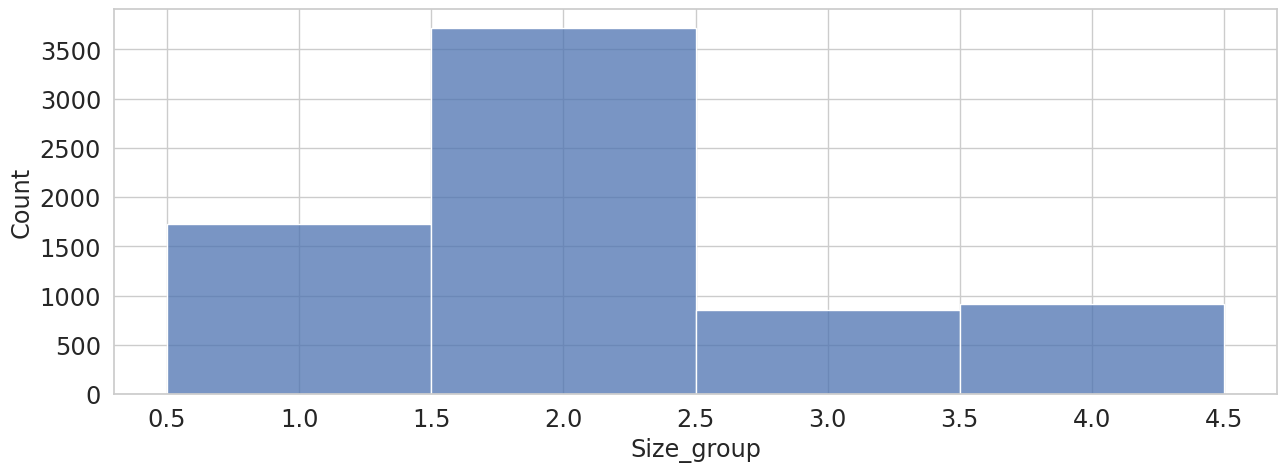

In [40]:

sns.histplot(housing_rent_clean_encod['Size_group'])


In [41]:
from sklearn.model_selection import train_test_split

housing_rent_train, housing_rent_test = train_test_split(housing_rent_clean_encod, test_size=0.2, stratify=housing_rent_clean_encod['Size_group'], random_state=42)

In [42]:
housing_rent_train.shape

(5782, 108)

In [43]:
housing_rent_train.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,...,District_Vila Leopoldina/São Paulo,District_Vila Madalena/São Paulo,District_Vila Maria/São Paulo,District_Vila Mariana/São Paulo,District_Vila Matilde/São Paulo,District_Vila Olimpia/São Paulo,District_Vila Prudente/São Paulo,District_Vila Sônia/São Paulo,District_Água Rasa/São Paulo,Size_group
10890,2100,597,78,3,2,1,2,0,0,1,...,0,0,0,0,0,0,0,0,0,2
10645,4000,1000,103,2,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3409,3500,620,49,1,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3778,4000,2700,111,2,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
1938,2500,465,36,1,2,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [44]:
# proportion of the groups in the training set
housing_rent_train['Size_group'].value_counts() / len(housing_rent_train['Size_group'])

2    0.514874
1    0.238845
4    0.127292
3    0.118990
Name: Size_group, dtype: float64

In [45]:
housing_rent_test.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,...,District_Vila Leopoldina/São Paulo,District_Vila Madalena/São Paulo,District_Vila Maria/São Paulo,District_Vila Mariana/São Paulo,District_Vila Matilde/São Paulo,District_Vila Olimpia/São Paulo,District_Vila Prudente/São Paulo,District_Vila Sônia/São Paulo,District_Água Rasa/São Paulo,Size_group
3331,4000,1123,160,3,4,3,3,0,0,1,...,0,0,0,0,0,0,0,0,0,4
3171,1500,971,95,3,2,1,2,0,0,1,...,0,0,0,0,0,0,0,0,0,2
10803,10000,2250,208,4,5,4,4,0,0,1,...,0,0,0,1,0,0,0,0,0,4
9205,2700,861,58,2,2,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,2
1203,5800,1169,110,2,2,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,3


In [46]:
housing_rent_test.shape

(1446, 108)

In [47]:
# proportion of the groups in the testing set
housing_rent_test['Size_group'].value_counts() / len(housing_rent_test['Size_group'])

2    0.514523
1    0.239281
4    0.127248
3    0.118949
Name: Size_group, dtype: float64

In [48]:
# removing the attribute 'median_income_group'
housing_rent_train = housing_rent_train.drop(columns=['Size_group'])
housing_rent_test = housing_rent_test.drop(columns=['Size_group'])

In [49]:
# if you want to keep the reference for the row indices from the original dataset, remove the index=False
housing_rent_train.to_csv('./sample_data/housing_rent_train.csv', index=False)
housing_rent_test.to_csv('./sample_data/housing_rent_test.csv', index=False)

##3.5 Summary of the preprocessing and cleaning of the dataset

In this step the dataset was sliced and reduced only to the attributes that help predict the rent value of the apartments. This should contribute to more efficiency in the subsequent steps of this development.

The missing values from the "Condo" attribute were replaced by its median value so all instances of the original dataset could be maintained for subsequent analysis.

The categorical attribute "District" was submitted to one hot enconding and converted into numerical values so it can be considered for the regression analysis model being pursued.

Lastly, in order to avoid bias selection, the core predictor attribute "Size" was segmented into four groups (strata) that were taken into consideration for a stratified sampling step.

Taken together, all the actions performed during the preprocessing and cleaning step should contribute to a more efficient and precise training of the regression model.



#**4. Training and validating the model**

##4.1 First model: Linear regression

In [114]:
housing_rent_train = pd.read_csv('./sample_data/housing_rent_train.csv')
housing_rent_test = pd.read_csv('./sample_data/housing_rent_test.csv')

In [115]:
housing_rent_train.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,...,District_Vila Jacuí/São Paulo,District_Vila Leopoldina/São Paulo,District_Vila Madalena/São Paulo,District_Vila Maria/São Paulo,District_Vila Mariana/São Paulo,District_Vila Matilde/São Paulo,District_Vila Olimpia/São Paulo,District_Vila Prudente/São Paulo,District_Vila Sônia/São Paulo,District_Água Rasa/São Paulo
0,2100,597,78,3,2,1,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,4000,1000,103,2,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3500,620,49,1,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4000,2700,111,2,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2500,465,36,1,2,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [51]:
housing_rent_train_target = housing_rent_train['Price'].copy()  # y = 1D array
housing_rent_train_pre = housing_rent_train.drop(columns=['Price'])  # X = 2D array, feature matrix


6.1. Getting the independent (features) and dependent variables (outcome)

In [52]:
type(housing_rent_train_pre)

pandas.core.frame.DataFrame

In [53]:
type(housing_rent_train_target)

pandas.core.series.Series

In [54]:
# convert Pandas to numpy arrays
X_train = housing_rent_train_pre.values
y_train = housing_rent_train_target.values

In [55]:
housing_rent_train_pre.head()

,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,...,District_Vila Jacuí/São Paulo,District_Vila Leopoldina/São Paulo,District_Vila Madalena/São Paulo,District_Vila Maria/São Paulo,District_Vila Mariana/São Paulo,District_Vila Matilde/São Paulo,District_Vila Olimpia/São Paulo,District_Vila Prudente/São Paulo,District_Vila Sônia/São Paulo,District_Água Rasa/São Paulo
10890,597,78,3,2,1,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10645,1000,103,2,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3409,620,49,1,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3778,2700,111,2,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1938,465,36,1,2,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
X_train[:5]

array([[ 5.97000000e+02,  7.80000000e+01,  3.00000000e+00,
         2.00000000e+00,  1.00000000e+00,  2.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00, -2.35521376e+01, -4.67430944e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+0

In [57]:
X_train[:, 3]

array([2., 1., 2., ..., 2., 2., 2.])

In [58]:
y_train.shape

(5782,)

6.2. Training the Models

In [59]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()  # default hyperparameters

# training
lin_reg.fit(X_train, y_train)

LinearRegression()

In [125]:
### saving the model
import joblib
joblib.dump(lin_reg, './sample_data/model1_LR.pkl')

['./sample_data/model1_LR.pkl']

6.3. Evaluating on the Training Set

In [60]:
y_train_pred = lin_reg.predict(X_train)

In [61]:
r2_score = lin_reg.score(X_train, y_train)
print(f'R2 = {r2_score}')

R2 = 0.6983442716688957


In [62]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f'RMSE = {rmse}')

RMSE = 1973.25673956387


Text(0.5, 1.0, 'Rent value - Prediction vs Real')

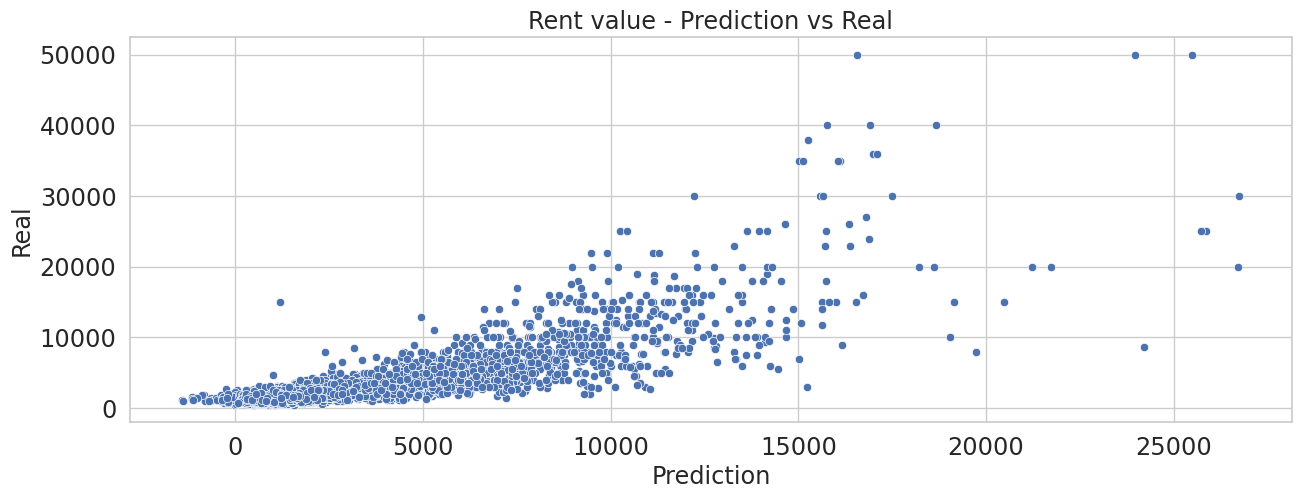

In [63]:
sns.scatterplot(x=y_train_pred, y=y_train)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Rent value - Prediction vs Real')

In [64]:
residual = y_train - y_train_pred

Text(0.5, 1.0, 'Rent value - Prediction vs Residual')

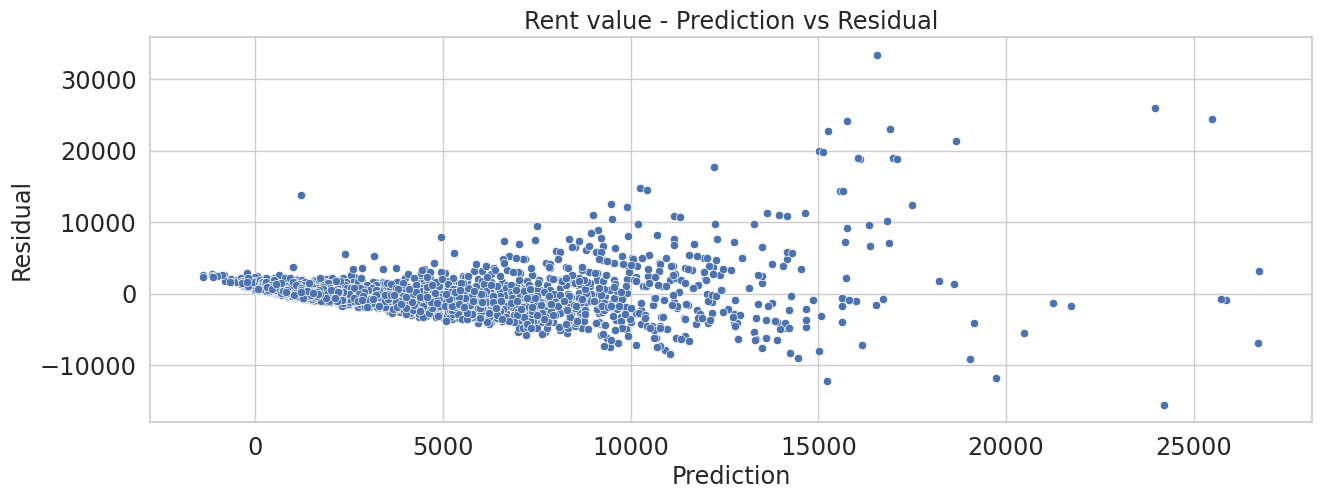

In [65]:
sns.scatterplot(x=y_train_pred, y=residual)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Rent value - Prediction vs Residual')

<Axes: ylabel='Count'>

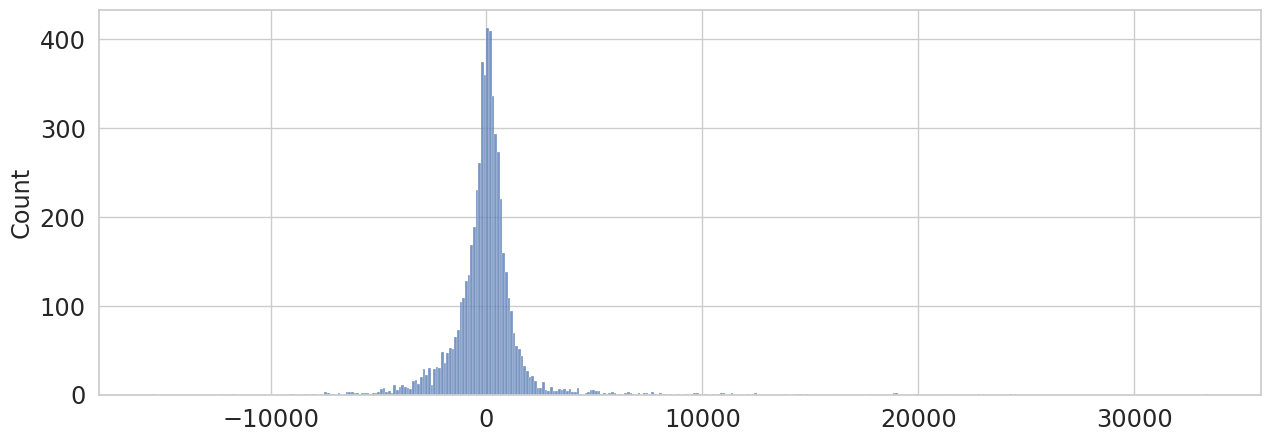

In [66]:
sns.histplot(residual)

##4.2 Second model: Linear regression w/ feature scalling

In [144]:
housing_rent_train = pd.read_csv('./sample_data/housing_rent_train.csv')
housing_rent_test = pd.read_csv('./sample_data/housing_rent_test.csv')

In [145]:
housing_rent_train.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,...,District_Vila Jacuí/São Paulo,District_Vila Leopoldina/São Paulo,District_Vila Madalena/São Paulo,District_Vila Maria/São Paulo,District_Vila Mariana/São Paulo,District_Vila Matilde/São Paulo,District_Vila Olimpia/São Paulo,District_Vila Prudente/São Paulo,District_Vila Sônia/São Paulo,District_Água Rasa/São Paulo
0,2100,597,78,3,2,1,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,4000,1000,103,2,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3500,620,49,1,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4000,2700,111,2,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2500,465,36,1,2,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [146]:
housing_rent_train_target = housing_rent_train['Price'].copy()  # y = 1D array
housing_rent_train_pre = housing_rent_train.drop(columns=['Price'])  # X = 2D array, feature matrix

In [147]:
housing_rent_train_pre.columns.values

array(['Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking',
       'Elevator', 'Furnished', 'Swimming Pool', 'New', 'Latitude',
       'Longitude', 'District_Alto de Pinheiros/São Paulo',
       'District_Anhanguera/São Paulo', 'District_Aricanduva/São Paulo',
       'District_Artur Alvim/São Paulo', 'District_Barra Funda/São Paulo',
       'District_Bela Vista/São Paulo', 'District_Belém/São Paulo',
       'District_Bom Retiro/São Paulo', 'District_Brasilândia/São Paulo',
       'District_Brooklin/São Paulo', 'District_Brás/São Paulo',
       'District_Butantã/São Paulo', 'District_Cachoeirinha/São Paulo',
       'District_Cambuci/São Paulo', 'District_Campo Belo/São Paulo',
       'District_Campo Grande/São Paulo',
       'District_Campo Limpo/São Paulo', 'District_Cangaíba/São Paulo',
       'District_Capão Redondo/São Paulo', 'District_Carrão/São Paulo',
       'District_Casa Verde/São Paulo',
       'District_Cidade Ademar/São Paulo',
       'District_Cidade Dutra/São Paulo',

In [148]:
numeric_variables = ['Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Latitude', 'Longitude']
dummy_variables = ['Elevator', 'Furnished', 'Swimming Pool','New', 'District_Alto de Pinheiros/São Paulo', 'District_Anhanguera/São Paulo', 'District_Aricanduva/São Paulo', 'District_Artur Alvim/São Paulo', 'District_Barra Funda/São Paulo', 'District_Bela Vista/São Paulo', 'District_Belém/São Paulo', 'District_Bom Retiro/São Paulo', 'District_Brasilândia/São Paulo', 'District_Brooklin/São Paulo', 'District_Brás/São Paulo', 'District_Butantã/São Paulo', 'District_Cachoeirinha/São Paulo', 'District_Cambuci/São Paulo', 'District_Campo Belo/São Paulo', 'District_Campo Grande/São Paulo', 'District_Campo Limpo/São Paulo', 'District_Cangaíba/São Paulo','District_Capão Redondo/São Paulo', 'District_Carrão/São Paulo', 'District_Casa Verde/São Paulo','District_Cidade Ademar/São Paulo', 'District_Cidade Dutra/São Paulo', 'District_Cidade Líder/São Paulo', 'District_Cidade Tiradentes/São Paulo', 'District_Consolação/São Paulo', 'District_Cursino/São Paulo', 'District_Ermelino Matarazzo/São Paulo','District_Freguesia do Ó/São Paulo', 'District_Grajaú/São Paulo', 'District_Guaianazes/São Paulo', 'District_Iguatemi/São Paulo', 'District_Ipiranga/São Paulo', 'District_Itaim Bibi/São Paulo', 'District_Itaim Paulista/São Paulo', 'District_Itaquera/São Paulo','District_Jabaquara/São Paulo', 'District_Jaguaré/São Paulo','District_Jaraguá/São Paulo', 'District_Jardim Helena/São Paulo', 'District_Jardim Paulista/São Paulo', 'District_Jardim São Luis/São Paulo', 'District_Jardim Ângela/São Paulo', 'District_Jaçanã/São Paulo', 'District_José Bonifácio/São Paulo', 'District_Lajeado/São Paulo', 'District_Lapa/São Paulo', 'District_Liberdade/São Paulo','District_Limão/São Paulo', 'District_Mandaqui/São Paulo', 'District_Medeiros/São Paulo', 'District_Moema/São Paulo', 'District_Mooca/São Paulo', 'District_Morumbi/São Paulo','District_Pari/São Paulo', 'District_Parque do Carmo/São Paulo', 'District_Pedreira/São Paulo', 'District_Penha/São Paulo', 'District_Perdizes/São Paulo', 'District_Pinheiros/São Paulo', 'District_Pirituba/São Paulo', 'District_Ponte Rasa/São Paulo', 'District_Raposo Tavares/São Paulo', 'District_República/São Paulo', 'District_Rio Pequeno/São Paulo', 'District_Sacomã/São Paulo', 'District_Santa Cecília/São Paulo', 'District_Santana/São Paulo', 'District_Santo Amaro/São Paulo', 'District_Sapopemba/São Paulo', 'District_Saúde/São Paulo', 'District_Socorro/São Paulo', 'District_São Lucas/São Paulo', 'District_São Mateus/São Paulo', 'District_São Miguel/São Paulo', 'District_São Rafael/São Paulo', 'District_Sé/São Paulo', 'District_Tatuapé/São Paulo', 'District_Tremembé/São Paulo', 'District_Tucuruvi/São Paulo', 'District_Vila Andrade/São Paulo', 'District_Vila Curuçá/São Paulo', 'District_Vila Formosa/São Paulo', 'District_Vila Guilherme/São Paulo','District_Vila Jacuí/São Paulo', 'District_Vila Leopoldina/São Paulo', 'District_Vila Madalena/São Paulo', 'District_Vila Maria/São Paulo', 'District_Vila Mariana/São Paulo','District_Vila Matilde/São Paulo','District_Vila Olimpia/São Paulo', 'District_Vila Prudente/São Paulo', 'District_Vila Sônia/São Paulo', 'District_Água Rasa/São Paulo']

In [149]:
X_train_numeric = housing_rent_train_pre[numeric_variables].values
X_train_dummy = housing_rent_train_pre[dummy_variables].values

In [150]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

# learn the median and IQR for each feature from our training (numeric) set
scaler.fit(X_train_numeric)

RobustScaler()

In [151]:
print(f'center: {scaler.center_}\n')

center: [597.          67.           2.           2.           1.
   1.         -23.55705695 -46.64516655]



In [152]:

print(f'scale: {scaler.scale_}\n')

scale: [5.3800000e+02 4.8000000e+01 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 7.5972775e-02 1.0391310e-01]



In [153]:

# median
housing_rent_train_pre['Condo'].median()

597.0

In [154]:
# IQR
Q1 = housing_rent_train_pre['Condo'].quantile(0.25)
Q3 = housing_rent_train_pre['Condo'].quantile(0.75)

IQR = Q3 - Q1

IQR

538.0

In [155]:
# applying feature scaling
X_train_numeric_norm = scaler.transform(X_train_numeric)

In [156]:

X_train_numeric_norm

array([[ 0.        ,  0.22916667,  1.        , ...,  1.        ,
         0.06475148, -0.94240139],
       [ 0.74907063,  0.75      ,  0.        , ...,  0.        ,
        -0.22010977, -0.09300319],
       [ 0.04275093, -0.375     , -1.        , ...,  0.        ,
        -0.83711369, -0.30955144],
       ...,
       [ 2.42193309, -0.10416667, -1.        , ...,  1.        ,
        -0.35240321, -0.36929367],
       [-0.366171  , -0.25      ,  0.        , ...,  0.        ,
        -1.54458028, -0.66829351],
       [ 0.09479554,  1.3125    ,  1.        , ..., -1.        ,
         0.04552223, -0.12677276]])

In [157]:
# our final normalized training set
X_train = np.hstack((X_train_numeric_norm, X_train_dummy))

In [158]:
X_train

array([[ 0.        ,  0.22916667,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.74907063,  0.75      ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04275093, -0.375     , -1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.42193309, -0.10416667, -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.366171  , -0.25      ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09479554,  1.3125    ,  1.        , ...,  0.        ,
         0.        ,  0.        ]])

In [159]:
# we already have X_train
y_train = housing_rent_train_target.values
y_train

array([2100, 4000, 3500, ..., 7200, 1600, 3600])

In [160]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()  # default parameters
lin_reg.fit(X_train, y_train)

LinearRegression()

In [161]:
### saving the model
import joblib
joblib.dump(lin_reg, './sample_data/model2_LR_FS.pkl')

['./sample_data/model2_LR_FS.pkl']

In [162]:
y_train_pred_lin_reg = lin_reg.predict(X_train)

In [163]:
from sklearn.metrics import r2_score

lin_reg_r2 = r2_score(y_train, y_train_pred_lin_reg)
print(f'R² linear regression = {lin_reg_r2}')

R² linear regression = 0.6983442721237421


In [164]:
from sklearn.metrics import mean_squared_error

lin_reg_rmse = mean_squared_error(y_train, y_train_pred_lin_reg, squared=False)
print(f'RMSE = {lin_reg_rmse}')

RMSE = 1973.2567380761996


Text(0.5, 1.0, 'Median housing value - Prediction vs Real - Linear Regression')

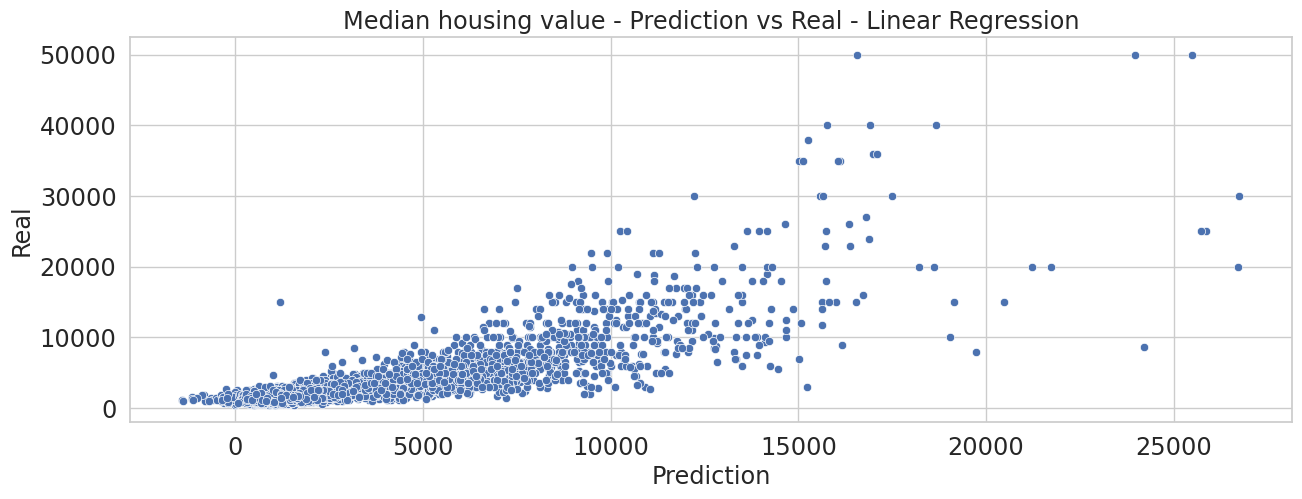

In [165]:
sns.scatterplot(x=y_train_pred_lin_reg, y=y_train)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Median housing value - Prediction vs Real - Linear Regression')

Text(0.5, 1.0, 'Median housing value - Prediction vs Residual - Linear Regression')

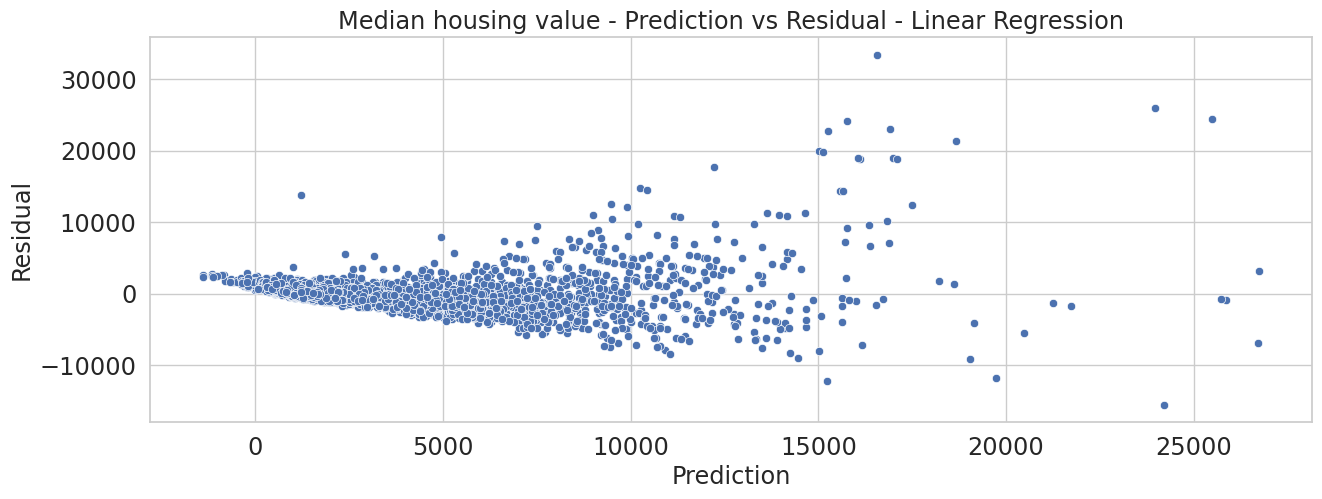

In [166]:
residual_lin_reg = y_train - y_train_pred_lin_reg

sns.scatterplot(x=y_train_pred_lin_reg, y=residual_lin_reg)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Median housing value - Prediction vs Residual - Linear Regression')

## 4.3 Third model: Decision Trees w/ feature scalling

In [108]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()  # default hyperparameters
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [124]:
### saving the model
import joblib
joblib.dump(tree_reg, './sample_data/model3_DT_FS.pkl')

['./sample_data/model3_DT.pkl']

In [109]:
y_train_pred_tree_reg = tree_reg.predict(X_train)

In [110]:
from sklearn.metrics import r2_score

tree_reg_r2 = r2_score(y_train, y_train_pred_tree_reg)
print(f'R² decision tree regression = {tree_reg_r2}')

R² decision tree regression = 0.9998649553917424


In [111]:
from sklearn.metrics import mean_squared_error

tree_reg_rmse = mean_squared_error(y_train, y_train_pred_tree_reg, squared=False)
print(f'RMSE = {tree_reg_rmse}')

RMSE = 41.75095665405624


Text(0.5, 1.0, 'Median housing value - Prediction vs Real - Decision Tree Regression')

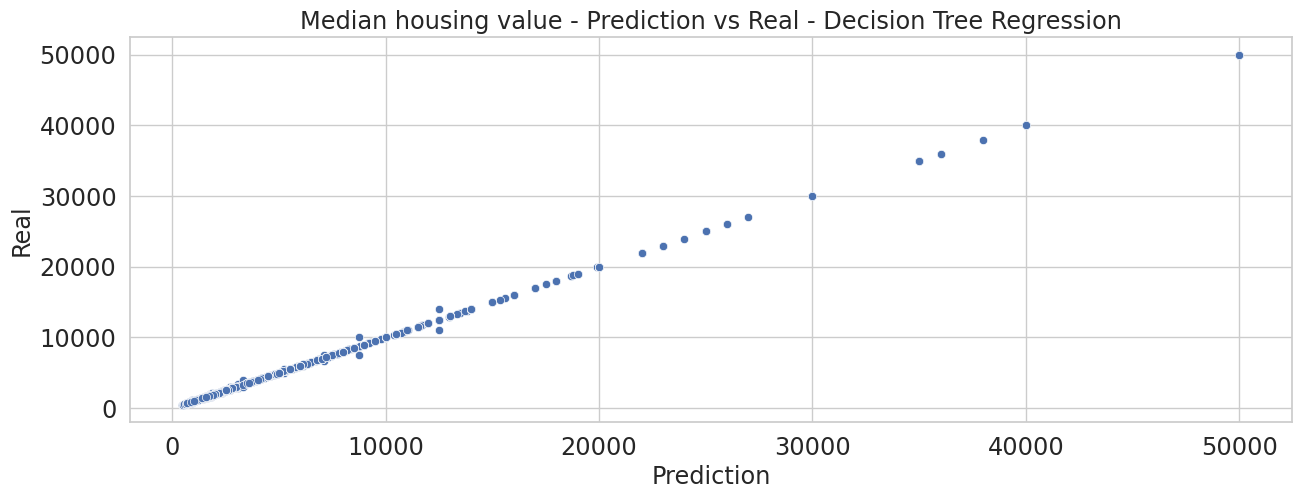

In [112]:
sns.scatterplot(x=y_train_pred_tree_reg, y=y_train)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.title('Median housing value - Prediction vs Real - Decision Tree Regression')

Text(0.5, 1.0, 'Median housing value - Prediction vs Residual |')

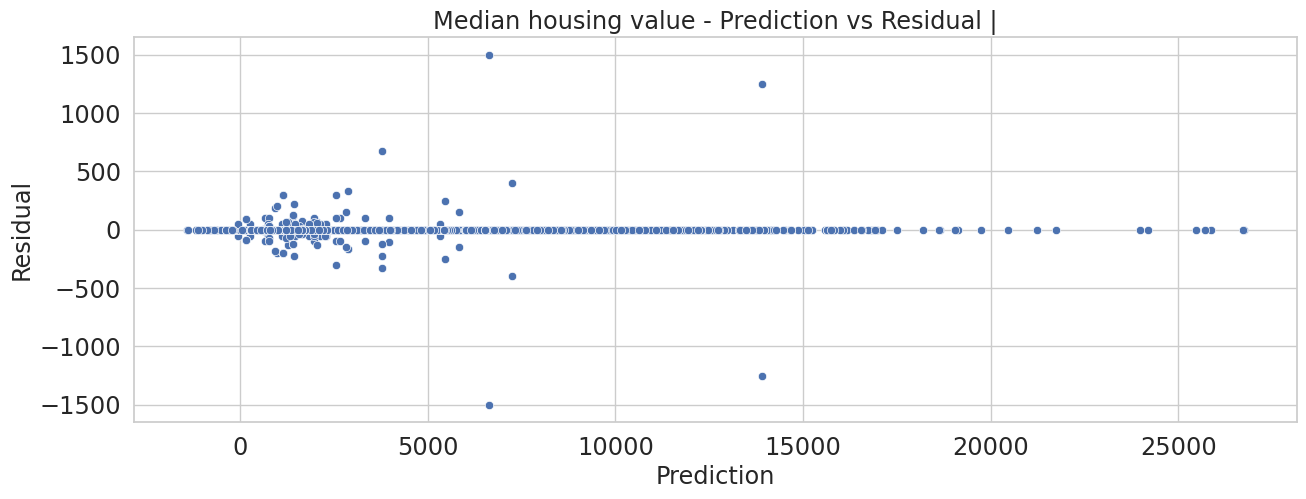

In [113]:
residual_tree_reg = y_train - y_train_pred_tree_reg

sns.scatterplot(x=y_train_pred_lin_reg, y=residual_tree_reg)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Median housing value - Prediction vs Residual |')

##4.4 Discussion and cross-validation



The first model has shown an prediciton power (R2) of aproximately 69.8% and a typical prediction error of BRL 1973,00 in the rent price which although not bad, might be not satisfying either. This suggests that the model is still underfitting the training data. Also, the residual analysis of the first model has suggested that the variance is nonconstant therefore the assumption of homoscedasticity does not hold true.

The second model didnt show improvement.

The third model seems to be overfitting the data

The following code *randomly splits* (no stratification) the training set into 10 folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold (validation set) for evaluation every time and training on the other 9 folds (train-dev set).
The result is an array containing the 10 evaluation scores.

In [117]:
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor(random_state=42)
tree_neg_mse_scores = cross_val_score(tree_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

tree_rmse_scores = np.sqrt(-tree_neg_mse_scores)

In [118]:
# printing function
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [119]:
display_scores(tree_rmse_scores)

Scores: [3157.56829814 2480.12426395 2352.66927052 2583.38658404 2369.98700156
 3589.17855401 2696.76962495 2486.80649424 2010.91382811 2242.23687381]
Mean: 2596.964079332413
Standard deviation: 437.6280635405547


Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to perform worse than the Linear Regression model: mean cross-validation RMSE: $63,548 against $58,146 (linear regression).

Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation).
The Decision Tree has a score of approximately $63,548, generally ± $2,497.
We would not have this information if we just used one validation set (hold-out strategy).

But cross-validation comes at the cost of training the model several times, so it is not always possible.

In [120]:

from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_neg_mse_scores = cross_val_score(lin_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

lin_rmse_scores = np.sqrt(-lin_neg_mse_scores)

In [121]:
display_scores(lin_rmse_scores)

Scores: [2023.7587681  1762.22659282 2078.28687153 1826.78946022 1634.09939877
 2367.99581899 2481.58475436 1944.11881391 1639.45433966 2143.31909748]
Mean: 1990.1633915834864
Standard deviation: 273.3400997248305


That’s right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model:

Linear Regression: $58,371 ± $1,757
Decision Tree: $63,548 ± $2,497

##4.5 Evaluation under the test sample

In [ ]:
housing_rent_test = pd.read_csv('./sample_data/housing_rent_test.csv')

In [126]:
housing_rent_test.head()

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,...,District_Vila Jacuí/São Paulo,District_Vila Leopoldina/São Paulo,District_Vila Madalena/São Paulo,District_Vila Maria/São Paulo,District_Vila Mariana/São Paulo,District_Vila Matilde/São Paulo,District_Vila Olimpia/São Paulo,District_Vila Prudente/São Paulo,District_Vila Sônia/São Paulo,District_Água Rasa/São Paulo
0,4000,1123,160,3,4,3,3,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1500,971,95,3,2,1,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,10000,2250,208,4,5,4,4,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,2700,861,58,2,2,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5800,1169,110,2,2,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
housing_rent_test_target = housing_rent_train['Price'].copy()  # y = 1D array
housing_rent_test_pre = housing_rent_train.drop(columns=['Price'])  # X = 2D array, feature matrix

In [128]:
numeric_variables = ['Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking', 'Latitude', 'Longitude']
dummy_variables = ['Elevator', 'Furnished', 'Swimming Pool','New', 'District_Alto de Pinheiros/São Paulo', 'District_Anhanguera/São Paulo', 'District_Aricanduva/São Paulo', 'District_Artur Alvim/São Paulo', 'District_Barra Funda/São Paulo', 'District_Bela Vista/São Paulo', 'District_Belém/São Paulo', 'District_Bom Retiro/São Paulo', 'District_Brasilândia/São Paulo', 'District_Brooklin/São Paulo', 'District_Brás/São Paulo', 'District_Butantã/São Paulo', 'District_Cachoeirinha/São Paulo', 'District_Cambuci/São Paulo', 'District_Campo Belo/São Paulo', 'District_Campo Grande/São Paulo', 'District_Campo Limpo/São Paulo', 'District_Cangaíba/São Paulo','District_Capão Redondo/São Paulo', 'District_Carrão/São Paulo', 'District_Casa Verde/São Paulo','District_Cidade Ademar/São Paulo', 'District_Cidade Dutra/São Paulo', 'District_Cidade Líder/São Paulo', 'District_Cidade Tiradentes/São Paulo', 'District_Consolação/São Paulo', 'District_Cursino/São Paulo', 'District_Ermelino Matarazzo/São Paulo','District_Freguesia do Ó/São Paulo', 'District_Grajaú/São Paulo', 'District_Guaianazes/São Paulo', 'District_Iguatemi/São Paulo', 'District_Ipiranga/São Paulo', 'District_Itaim Bibi/São Paulo', 'District_Itaim Paulista/São Paulo', 'District_Itaquera/São Paulo','District_Jabaquara/São Paulo', 'District_Jaguaré/São Paulo','District_Jaraguá/São Paulo', 'District_Jardim Helena/São Paulo', 'District_Jardim Paulista/São Paulo', 'District_Jardim São Luis/São Paulo', 'District_Jardim Ângela/São Paulo', 'District_Jaçanã/São Paulo', 'District_José Bonifácio/São Paulo', 'District_Lajeado/São Paulo', 'District_Lapa/São Paulo', 'District_Liberdade/São Paulo','District_Limão/São Paulo', 'District_Mandaqui/São Paulo', 'District_Medeiros/São Paulo', 'District_Moema/São Paulo', 'District_Mooca/São Paulo', 'District_Morumbi/São Paulo','District_Pari/São Paulo', 'District_Parque do Carmo/São Paulo', 'District_Pedreira/São Paulo', 'District_Penha/São Paulo', 'District_Perdizes/São Paulo', 'District_Pinheiros/São Paulo', 'District_Pirituba/São Paulo', 'District_Ponte Rasa/São Paulo', 'District_Raposo Tavares/São Paulo', 'District_República/São Paulo', 'District_Rio Pequeno/São Paulo', 'District_Sacomã/São Paulo', 'District_Santa Cecília/São Paulo', 'District_Santana/São Paulo', 'District_Santo Amaro/São Paulo', 'District_Sapopemba/São Paulo', 'District_Saúde/São Paulo', 'District_Socorro/São Paulo', 'District_São Lucas/São Paulo', 'District_São Mateus/São Paulo', 'District_São Miguel/São Paulo', 'District_São Rafael/São Paulo', 'District_Sé/São Paulo', 'District_Tatuapé/São Paulo', 'District_Tremembé/São Paulo', 'District_Tucuruvi/São Paulo', 'District_Vila Andrade/São Paulo', 'District_Vila Curuçá/São Paulo', 'District_Vila Formosa/São Paulo', 'District_Vila Guilherme/São Paulo','District_Vila Jacuí/São Paulo', 'District_Vila Leopoldina/São Paulo', 'District_Vila Madalena/São Paulo', 'District_Vila Maria/São Paulo', 'District_Vila Mariana/São Paulo','District_Vila Matilde/São Paulo','District_Vila Olimpia/São Paulo', 'District_Vila Prudente/São Paulo', 'District_Vila Sônia/São Paulo', 'District_Água Rasa/São Paulo']

In [130]:
X_test_numeric = housing_rent_test_pre[numeric_variables].values
X_test_dummy = housing_rent_test_pre[dummy_variables].values

In [131]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

# learn the median and IQR for each feature from our training (numeric) set
scaler.fit(X_test_numeric)

RobustScaler()

In [132]:
print(f'center: {scaler.center_}\n')

center: [597.          67.           2.           2.           1.
   1.         -23.55705695 -46.64516655]



In [133]:

print(f'scale: {scaler.scale_}\n')

scale: [5.3800000e+02 4.8000000e+01 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 7.5972775e-02 1.0391310e-01]



In [134]:

# median
housing_rent_test_pre['Condo'].median()

597.0

In [135]:
# IQR
Q1 = housing_rent_test_pre['Condo'].quantile(0.25)
Q3 = housing_rent_test_pre['Condo'].quantile(0.75)

IQR = Q3 - Q1

IQR

538.0

In [136]:
# applying feature scaling
X_test_numeric_norm = scaler.transform(X_test_numeric)

In [137]:

X_test_numeric_norm

array([[ 0.        ,  0.22916667,  1.        , ...,  1.        ,
         0.06475148, -0.94240139],
       [ 0.74907063,  0.75      ,  0.        , ...,  0.        ,
        -0.22010977, -0.09300319],
       [ 0.04275093, -0.375     , -1.        , ...,  0.        ,
        -0.83711369, -0.30955144],
       ...,
       [ 2.42193309, -0.10416667, -1.        , ...,  1.        ,
        -0.35240321, -0.36929367],
       [-0.366171  , -0.25      ,  0.        , ...,  0.        ,
        -1.54458028, -0.66829351],
       [ 0.09479554,  1.3125    ,  1.        , ..., -1.        ,
         0.04552223, -0.12677276]])

In [138]:
# our final normalized training set
X_test = np.hstack((X_test_numeric_norm, X_test_dummy))

In [139]:
X_test

array([[ 0.        ,  0.22916667,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.74907063,  0.75      ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04275093, -0.375     , -1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.42193309, -0.10416667, -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.366171  , -0.25      ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09479554,  1.3125    ,  1.        , ...,  0.        ,
         0.        ,  0.        ]])

In [140]:
# we already have X_test
y_test = housing_rent_test_target.values
y_test

array([2100, 4000, 3500, ..., 7200, 1600, 3600])

In [167]:
### loading the trained model
lin_reg = joblib.load('./sample_data/model2_LR_FS.pkl')

In [168]:
### evaluation
y_test_pred = lin_reg.predict(X_test)

In [169]:
### computing the final score
from sklearn.metrics import mean_squared_error

lin_rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'RMSE Lin. Reg. in the Test Set: {lin_rmse_test}')

RMSE Lin. Reg. in the Test Set: 1973.2567380761996


By using our linear regression, the RMSE for the Test Set -- which has never been seen/used before -- is $ 59,439.63.
This error is slightly higher than the cross-validation error score $58,371.04 ± $1,757.91, which tends to be common specially when fine-tunning the hyperparameters.

We need now to compare solution with the current baseline

##4.6 Next steps and future work

The final performance of our linear regression model ($ 59,439.63) is not better than the experts’ price estimates ($47,911.00), which were often off by about 20%. Therefore, it is not prepared to launch in production. We need to find a better model.

We may follow some strategies to find a better model than our current one:

Evaluate many other different models/algorithms (e.g., Polynomial regression, KNN regression, SVM regression, ...)
Apply some feature selection method;
Perform fine-tunning to find the best hyperparaments
Try ensemble methods
After all, a model with a score similar to the baseline might be enough. Even though it is not more accurate (or with a lower error) than the baseline, the fact that the model is automatic will frees up some time for the experts so they can work on more interesting and productive tasks.